# 12.3 파인 튜닝의 구현
  

리스트12.7 각 설정

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam

optimizer = Adam()

img_size = 64  # 이미지의 폭과 높이
n_channel = 3  # 채널 수
n_mid = 256  # 중간층의 뉴런 수

batch_size = 32
epochs = 20

리스트12.8 VGG16의 도입

In [3]:
from tensorflow.keras.applications import VGG16

model_vgg16 = VGG16(weights="imagenet",  # ImageNet에서 학습한 파라미터를 사용
                 include_top=False,  # 전결합층을 포함하지 않는다
                 input_shape=(img_size, img_size, n_channel))  # 입력의 형태
model_vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

리스트12.9 CIFAR-10 읽어 들이기

In [4]:
from tensorflow.keras.datasets import cifar10

(x_train, t_train), (x_test, t_test) = cifar10.load_data()

# 라벨이 0과 1의 데이터만 꺼낸다
t_train = t_train.reshape(-1)
t_test = t_test.reshape(-1)
x_train = x_train[t_train <= 1]
t_train = t_train[t_train <= 1]
x_test = x_test[t_test <= 1]
t_test = t_test[t_test <= 1]

print("Original size:", x_train.shape)

# 이미지를 확대
x_train = x_train.repeat(2, axis=1).repeat(2, axis=2)
x_test = x_test.repeat(2, axis=1).repeat(2, axis=2)

print("Input size:", x_train.shape)

170508288/170498071 [==============================] - 13s 0us/step
Original size: (10000, 32, 32, 3)
Input size: (10000, 64, 64, 3)


리스트12.10 파인 튜닝용 모델을 구축한다


In [5]:
model = Sequential()
model.add(model_vgg16)

model.add(Flatten())  # 1차원의 배열로 변환
model.add(Dense(n_mid))
model.add(Activation("relu"))
model.add(Dropout(0.5))  # 드롭 아웃
model.add(Dense(1))
model.add(Activation("sigmoid"))

# block5만 훈련한다
for layer in model_vgg16.layers:
    if layer.name.startswith("block5_conv"):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
 activation_1 (Activation)   (None, 1)                 0

리스트12.11 모델의 학습  

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x_train = x_train / 255  # 0에서 1의 범위에 넣는다
x_test = x_test / 255

# 데이터 확장
generator = ImageDataGenerator(
           rotation_range=0.2,
           width_shift_range=0.2,
           height_shift_range=0.2,
           shear_range=10,
           zoom_range=0.2,
           horizontal_flip=True)
generator.fit(x_train)

# 훈련
history = model.fit(generator.flow(x_train, t_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, t_test))

Epoch 1/20
313/313 [==============================] - 27s 50ms/step - loss: 0.2833 - accuracy: 0.8863 - val_loss: 0.1784 - val_accuracy: 0.9310
Epoch 2/20
313/313 [==============================] - 15s 48ms/step - loss: 0.1422 - accuracy: 0.9512 - val_loss: 0.0598 - val_accuracy: 0.9815
Epoch 3/20
313/313 [==============================] - 16s 49ms/step - loss: 0.1263 - accuracy: 0.9543 - val_loss: 0.0609 - val_accuracy: 0.9810
Epoch 4/20
313/313 [==============================] - 15s 48ms/step - loss: 0.1004 - accuracy: 0.9642 - val_loss: 0.0565 - val_accuracy: 0.9800
Epoch 5/20
313/313 [==============================] - 15s 48ms/step - loss: 0.0852 - accuracy: 0.9676 - val_loss: 0.0585 - val_accuracy: 0.9760
Epoch 6/20
313/313 [==============================] - 15s 47ms/step - loss: 0.0817 - accuracy: 0.9700 - val_loss: 0.1380 - val_accuracy: 0.9675
Epoch 7/20
313/313 [==============================] - 15s 47ms/step - loss: 0.0827 - accuracy: 0.9728 - val_loss: 0.0587 - val_accuracy:

리스트12.12 학습의 추이를 표시한다

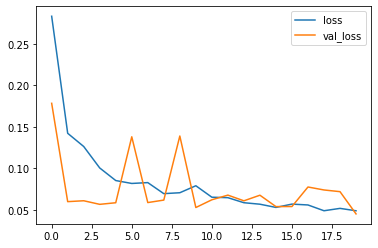

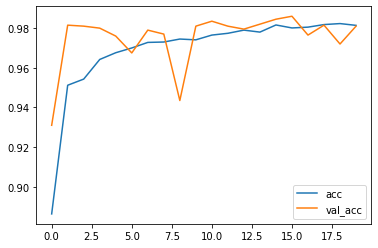

In [7]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']  # 훈련용 데이터의 오차
train_acc = history.history['accuracy']  # 훈련용 데이터의 정밀도
val_loss = history.history['val_loss']  # 검증용 데이터의 오차
val_acc = history.history['val_accuracy']  # 검증용 데이터의 정밀도

plt.plot(np.arange(len(train_loss)), train_loss, label='loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label='acc')
plt.plot(np.arange(len(val_acc)), val_acc, label='val_acc')
plt.legend()
plt.show()